# *Optical Tweezers* | Lab-Session #3
## Feb-15-2021 13:45

This jupyter notebook is a used to collect and analyse data during today's lab session

In [2]:
# Import the relevant libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.constants as const
import scipy.signal
import os
from csvlib import *
from scipy.optimize import curve_fit
from IPython.display import display
from PIL import Image
from tqdm import tqdm
import matplotlib.image as mpimg
from scipy.signal import butter, lfilter, freqz


# Display mpl in notebook format
%matplotlib inline

# Butterworth Filter
def butter_lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

# Data Collection

Data were collected for the calibration of the optical trap, by trapping a bead and plotting the power spectrum of each coordinate.

In [3]:
# open CSV files to numpy array
csvs = list_csv(PRINT='True')   # Lists CSV files in a given directory

def select_current(curr,csvs=csvs):
    indx = []
    for i,csv in enumerate(csvs):
        if str(curr) in csv.split('_')[2]:
            indx.append(i)
            
    return indx

List of .csv files in .
	 0 : TRP_09.95_100.csv
	 1 : TRP_09.95_200.csv
	 2 : TRP_09.95_300.csv
	 3 : TRP_11.00_100.csv
	 4 : TRP_11.00_200.csv
	 5 : TRP_11.00_300.csv
	 6 : TRP_11.99_100.csv
	 7 : TRP_11.99_200.csv
	 8 : TRP_11.99_300.csv
	 9 : TRP_13.02_100.csv
	 10 : TRP_13.02_200.csv
	 11 : TRP_13.02_300.csv
	 12 : TRP_14.00_100.csv
	 13 : TRP_14.00_200.csv
	 14 : TRP_14.00_300.csv
	 15 : TRP_15.02_100.csv
	 16 : TRP_15.02_200.csv
	 17 : TRP_15.02_300.csv
	 18 : TRP_16.00_100.csv
	 19 : TRP_16.00_200.csv
	 20 : TRP_16.00_300.csv
	 21 : TRP_16.95_200.csv
	 22 : TRP_16.95_300.csv
	 23 : TRP_18.00_200.csv
	 24 : TRP_18.00_300.csv
	 25 : TRP_18.98_100.csv
	 26 : TRP_18.98_200.csv
	 27 : TRP_18.98_300.csv
	 28 : TRP_20.00_100.csv
	 29 : TRP_20.00_200.csv
	 30 : TRP_20.00_300.csv


# Data Analysis

We are first going to plot the coordinates as imported form the qpd as a function of time

Data set under consideration: TRP_16.00_300.csv
The trap attempt is: 4.00μm


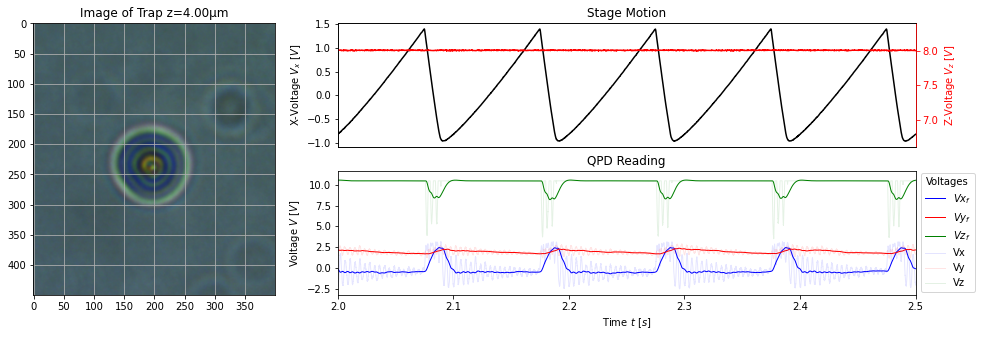

In [12]:
# Select a current and then see a family of curves for it.
indx = 20                       # Index of data file in the list
DATA = pd.read_csv(csvs[indx])  # Gets the CSV file as a Pandas Data Frame
data = DATA.to_numpy().T        # Gets data as a numpy array

# Extracting the relevant data
t = data[0]
x = data[1]
y = data[3]
z = data[5]
xs= data[7]
zs= data[9]

# Print Data frame information
print("Data set under consideration: "+csvs[indx])                 # Print filename
trp = "%.2f"%(20-float(csvs[indx].split('_')[1]))                   # Get trap number
trp_img = csvs[indx].split('_')[0]+'_'+csvs[indx].split('_')[1]    # Get trap image file
print("The trap attempt is: "+trp+'μm')                            # Print trap number

# Create a figure ##############################################
fig = plt.figure(figsize = (16,5), constrained_layout = False)
gs = fig.add_gridspec(2,3)

# Image axis
ax_img = fig.add_subplot(gs[0:,0])
ax_img.set_title('Image of Trap z='+trp+'μm')
img = mpimg.imread(trp_img+".tif")[400:850,370:770]
ax_img.imshow(img)
ax_img.grid()

# Plot Stage Displacement ######################################
ax_stg = fig.add_subplot(gs[0,1:])
ax_stg.set_title('Stage Motion')
ax_stg.set_ylabel(r'X-Voltage $V_x\ [V]$')
ax_stg.get_xaxis().set_visible(False)
ax_stg.set_xlim(2,2.5)

ax_stg.plot(t,xs,c='k')

ax_stgz = ax_stg.twinx()
ax_stgz.plot(t,zs,c='r')
scale = 1.05
offset = -1
m = max(zs)*(scale-1)/scale + min(zs)*(2-scale)/scale + offset
M = max(zs) + min(zs)*(scale-1)/scale

ax_stgz.set_ylim(m,M)
ax_stgz.spines['right'].set_color('red')
ax_stgz.tick_params(axis='y', colors='red')
ax_stgz.yaxis.label.set_color('red')
ax_stgz.set_ylabel(r'Z-Voltage $V_z\ [V]$')

# Plot QPD Signal ###############################################
ax_qpd = fig.add_subplot(gs[1,1:],sharex = ax_stg)
ax_qpd.set_title('QPD Reading')
ax_qpd.set_xlabel(r'Time $t\ [s]$')
ax_qpd.set_ylabel(r'Voltage $V\ [V]$')

# Filter the singal
# Filter parameters
order = 2
fs = len(t)/(max(t)-min(t))      # sample rate
cutoff = 50                      # cutoff frequency

# The actual filtering
xf = butter_lowpass_filter(x, cutoff, fs, order)
yf = butter_lowpass_filter(y, cutoff, fs, order)
zf = butter_lowpass_filter(z, cutoff, fs, order)

# Plotting the filtered signals
ax_qpd.plot(t,xf,c='b',label=r'$Vx_f$',lw=1)
ax_qpd.plot(t,yf,c='r',label=r'$Vy_f$',lw=1)
ax_qpd.plot(t,zf,c='g',label=r'$Vz_f$',lw=1)

# Plotting the unfiltered signal
ax_qpd.plot(t,x,c='b',label='Vx',lw=1,alpha=0.1)
ax_qpd.plot(t,y,c='r',label='Vy',lw=1,alpha=0.1)
ax_qpd.plot(t,z,c='g',label='Vz',lw=1,alpha=0.1)
ax_qpd.legend(title='Voltages', bbox_to_anchor=(1., 1.03), loc='upper left')


11it [00:14,  1.28s/it]


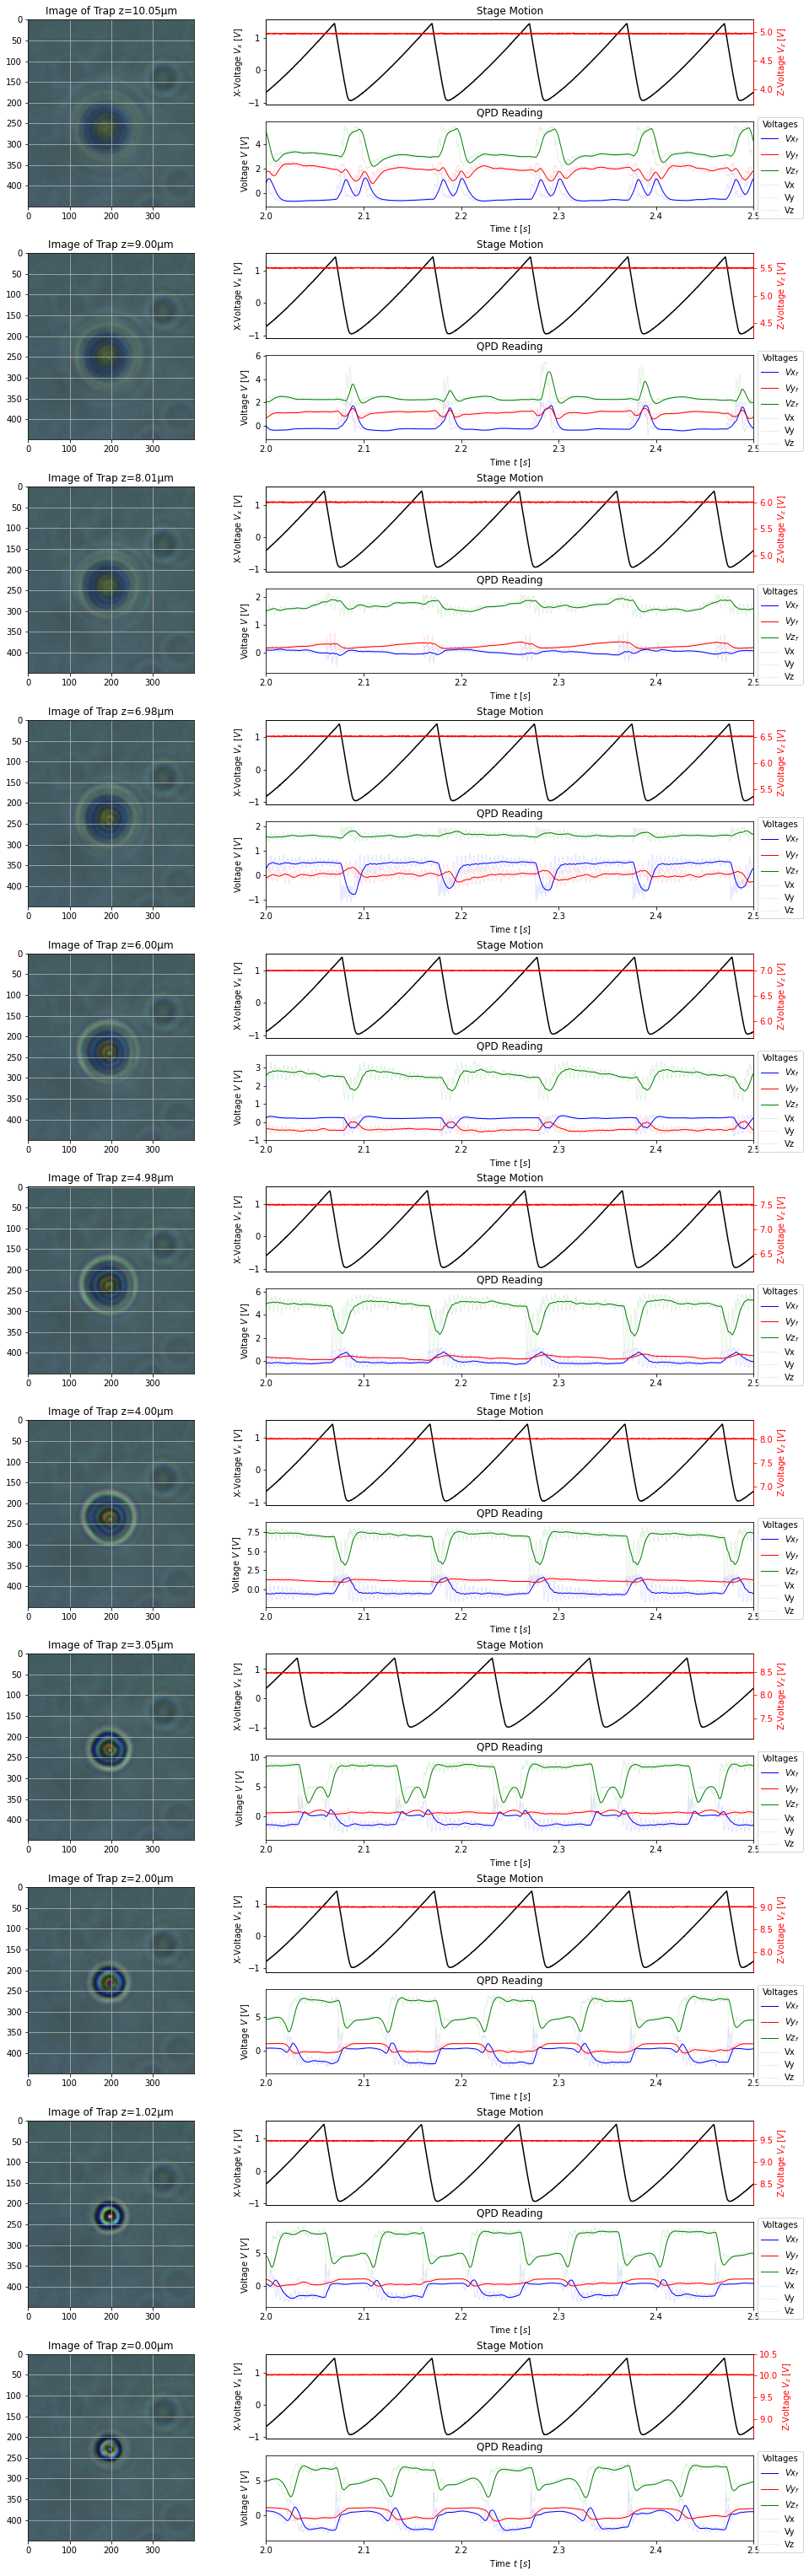

In [14]:
# Plot multiple indexes

# Get a set of indeces
indx = select_current(200)

# Create a figure ##############################################
fig = plt.figure(figsize = (16,5*len(indx)), constrained_layout = False)
fig.tight_layout()
gs = fig.add_gridspec(len(indx),1,hspace=0.25)

# For all the pictures
for i,ind in tqdm(enumerate(indx)):
    # Select a current and then see a family of curves for it.
    DATA = pd.read_csv(csvs[ind])   # Gets the CSV file as a Pandas Data Frame
    data = DATA.to_numpy().T        # Gets data as a numpy array
    gsi = gs[i].subgridspec(2,3)
    
    # Extracting the relevant data
    t = data[0]
    x = data[1]
    y = data[3]
    z = data[5]
    xs= data[7]
    zs= data[9]
    
    # Image axis
    trp = "%.2f"%(20-float(csvs[ind].split('_')[1]))                 # Get trap number
    trp_img = csvs[ind].split('_')[0]+'_'+csvs[ind].split('_')[1]    # Get trap image file
    
    ax_img = fig.add_subplot(gsi[0:,0])
    ax_img.set_title('Image of Trap z='+trp+'μm')
    img = mpimg.imread(trp_img+".tif")[400:850,370:770]
    ax_img.imshow(img)
    ax_img.grid()
    
    # Plot Stage Displacement ######################################
    ax_stg = fig.add_subplot(gsi[0,1:])
    ax_stg.set_title('Stage Motion')
    ax_stg.set_ylabel(r'X-Voltage $V_x\ [V]$')
    ax_stg.get_xaxis().set_visible(False)
    ax_stg.set_xlim(2,2.5)

    ax_stg.plot(t,xs,c='k')

    ax_stgz = ax_stg.twinx()
    ax_stgz.plot(t,zs,c='r')
    scale = 1.05
    offset = -1
    m = max(zs)*(scale-1)/scale + min(zs)*(2-scale)/scale + offset
    M = max(zs) + min(zs)*(scale-1)/scale

    ax_stgz.set_ylim(m,M)
    ax_stgz.spines['right'].set_color('red')
    ax_stgz.tick_params(axis='y', colors='red')
    ax_stgz.yaxis.label.set_color('red')
    ax_stgz.set_ylabel(r'Z-Voltage $V_z\ [V]$')

    # Plot QPD Signal ###############################################
    ax_qpd = fig.add_subplot(gsi[1,1:],sharex = ax_stg)
    ax_qpd.set_title('QPD Reading')
    ax_qpd.set_xlabel(r'Time $t\ [s]$')
    ax_qpd.set_ylabel(r'Voltage $V\ [V]$')

    # Filter the singal
    # Filter parameters
    order = 2
    fs = len(t)/(max(t)-min(t))      # sample rate
    cutoff = 50                      # cutoff frequency

    # The actual filtering
    xf = butter_lowpass_filter(x, cutoff, fs, order)
    yf = butter_lowpass_filter(y, cutoff, fs, order)
    zf = butter_lowpass_filter(z, cutoff, fs, order)

    # Plotting the filtered signals
    ax_qpd.plot(t,xf,c='b',label=r'$Vx_f$',lw=1)
    ax_qpd.plot(t,yf,c='r',label=r'$Vy_f$',lw=1)
    ax_qpd.plot(t,zf,c='g',label=r'$Vz_f$',lw=1)

    # Plotting the unfiltered signal
    ax_qpd.plot(t,x,c='b',label='Vx',lw=1,alpha=0.1)
    ax_qpd.plot(t,y,c='r',label='Vy',lw=1,alpha=0.1)
    ax_qpd.plot(t,z,c='g',label='Vz',lw=1,alpha=0.1)
    ax_qpd.legend(title='Voltages', bbox_to_anchor=(1., 1.1), loc='upper left')